In [1]:
import re
import json
import pandas as pd
import math
import numpy as np
import sklearn 
from functools import reduce


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

mobilepayments_df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
mobilepayments_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
df_newbal = mobilepayments_df.loc[mobilepayments_df.newbalanceDest > 0.0]
df_newbal.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
9,1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898.0,40348.79,0,0
10,1,DEBIT,9644.94,C1900366749,4465.0,0.00,C997608398,10845.0,157982.12,0,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.00,C476402209,5083.0,51513.44,0,0
21,1,DEBIT,9302.79,C1566511282,11299.0,1996.21,C1973538135,29832.0,16896.70,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.00,C932583850,6267.0,2719172.89,0,0


In [3]:
mobilepayments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Check if there are any null values in the dataset

In [4]:
mobilepayments_df.isnull().values.any()

False

In [5]:
mobilepayments_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Check the fraud transaction count.

In [6]:
mobilepayments_df["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [7]:
####mobilepayments_df["isFlaggedFraud"].value_counts()

In [8]:
mobilepayments_df.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


In [9]:
mobilepayments_df.skew()


step                0.375177
amount             30.993949
oldbalanceOrg       5.249136
newbalanceOrig      5.176884
oldbalanceDest     19.921758
newbalanceDest     19.352302
isFraud            27.779538
isFlaggedFraud    630.603629
dtype: float64

Create a dataframe with only fraud transactions for further data analysis

In [2]:
df_fraud = mobilepayments_df.loc[mobilepayments_df.isFraud == 1]

In [11]:
df_fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


Check what type of transactions contribute to Fraud transactions

In [12]:
df_fraud['type'].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

Only CASH_OUT and TRANSFER transaction types are contributing to Fraud.

In [3]:
df_flaggedfraud = mobilepayments_df.loc[mobilepayments_df.isFlaggedFraud == 1]

In [14]:
df_flaggedfraud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 2736446 to 6362584
Data columns (total 11 columns):
step              16 non-null int64
type              16 non-null object
amount            16 non-null float64
nameOrig          16 non-null object
oldbalanceOrg     16 non-null float64
newbalanceOrig    16 non-null float64
nameDest          16 non-null object
oldbalanceDest    16 non-null float64
newbalanceDest    16 non-null float64
isFraud           16 non-null int64
isFlaggedFraud    16 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 1.5+ KB


In [15]:
##df_flaggedfraud

All the transactions that have isFlaggedFraud set as True are all marked as isFraud = True. We can safely exclude the column isFlaggedFraud without impacting the final predictions.

In [4]:
mobilepayments_df.drop(columns="isFlaggedFraud", axis=1, inplace=True)
mobilepayments_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


From data analysis, we can determine that only CASH_OUT and TRANSFER type of transactions are having fraud transactions. We can remove other type of transactions as they do not contribute to the fraud and need not be included in the model.

In [5]:
filtered_payments_df = mobilepayments_df[mobilepayments_df['type'].isin(["TRANSFER","CASH_OUT"])]

In [18]:
filtered_payments_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0


In [19]:
filtered_payments_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 10 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
dtypes: float64(5), int64(2), object(3)
memory usage: 232.5+ MB


In [20]:
filtered_payments_df.isFraud.value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [6]:
fraud_trans_df = filtered_payments_df.loc[filtered_payments_df.isFraud == 1]

There is no single or particular group of  Origination or Destination parties contributing to fraud transactions. We can ignore the nameOrig and nameDest columns as they do not contribute much for fraud predictions.

In [7]:
filtered_payments_df.drop(columns=["nameOrig","nameDest"], axis=1, inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
dest_0_df = (filtered_payments_df.loc[(filtered_payments_df.amount !=0) & (filtered_payments_df.oldbalanceDest == 0)& (filtered_payments_df.newbalanceDest == 0)])

In [24]:
dest_0_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5776 entries, 2 to 6362618
Data columns (total 8 columns):
step              5776 non-null int64
type              5776 non-null object
amount            5776 non-null float64
oldbalanceOrg     5776 non-null float64
newbalanceOrig    5776 non-null float64
oldbalanceDest    5776 non-null float64
newbalanceDest    5776 non-null float64
isFraud           5776 non-null int64
dtypes: float64(5), int64(2), object(1)
memory usage: 406.1+ KB


In [25]:
dest_0_df.isFraud.value_counts()

1    4070
0    1706
Name: isFraud, dtype: int64

Out of 8213 fraud transactions 4070 (49.55%) transactions have both oldbalanceDest and newbalanceDest as 0 even though the the transfer amount is more than zero. This information seems to play a major role in the detection of fraud. In fact this could even be a category of fraud transactions.

In [9]:
Orig_0_df = (filtered_payments_df.loc[(filtered_payments_df.amount !=0) & (filtered_payments_df.oldbalanceOrg == 0)& (filtered_payments_df.newbalanceOrig == 0)])

In [27]:
Orig_0_df.isFraud.value_counts()

0    1308541
1         25
Name: isFraud, dtype: int64

Seems like the even if the transaction amount is not 0 but Original old balance and the original new balance are zeros doesn't classify as fraud. This type of transactions are contributing very less percentage to the fraud transactions. 

In [10]:
fraud_not_0_1 = fraud_trans_df.loc[(fraud_trans_df.amount != 0) & (fraud_trans_df.oldbalanceDest != 0) & (fraud_trans_df.newbalanceDest != 0)]

In [29]:
fraud_not_0_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2837 entries, 681 to 6362619
Data columns (total 10 columns):
step              2837 non-null int64
type              2837 non-null object
amount            2837 non-null float64
nameOrig          2837 non-null object
oldbalanceOrg     2837 non-null float64
newbalanceOrig    2837 non-null float64
nameDest          2837 non-null object
oldbalanceDest    2837 non-null float64
newbalanceDest    2837 non-null float64
isFraud           2837 non-null int64
dtypes: float64(5), int64(2), object(3)
memory usage: 243.8+ KB


In [30]:
fraud_not_0_1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.00,12145.85,1
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.00,9291619.62,1
1116,1,CASH_OUT,35063.63,C1635772897,35063.63,0.0,C1983025922,31140.00,7550.03,1
1870,1,CASH_OUT,25071.46,C1275464847,25071.46,0.0,C1364913072,9083.76,34155.22,1
3163,2,CASH_OUT,963532.14,C430329518,963532.14,0.0,C991505714,132382.57,1095914.71,1


For Transactions where the transaction amount is not 0 and the oldbalanceDest and newbalanceDest are not 0, it seems there is mismatch  in the oldbalanceDest and newbalanceDest after the transaction amount is applied. Meaning the newbalanceDest amounts are not having the expected amount when the transaction amount is applied to the oldbalanceDest. The difference between the expected value and the actual value in the transaction also diffetiates the fraud transactions. We can add one more feature to the dataset which has the difference in the expected value and the actual value in the newbalanceDest. (balancediffDest = oldbalanceDest + amount - newbalanceDest)


In [11]:
balancediffDest = filtered_payments_df.oldbalanceDest + filtered_payments_df.amount - filtered_payments_df.newbalanceDest

In [13]:
balancediffDest.shape

(2770409,)

In the same tone, we can also add calculate error in the Origination new balance and expected Origination new balance after the transaction amount is deducted and use that information for fraud analytics.

In [12]:
balancediffOrig = filtered_payments_df.oldbalanceOrg -  filtered_payments_df.amount -  filtered_payments_df.newbalanceOrig

In [34]:
balancediffOrig.shape

(2770409,)

Add the two new columns to the filtered_payments_df dataframe

In [13]:
filtered_payments_df['balanceDiffDest'] = balancediffDest
filtered_payments_df['balanceDiffOrig'] = balancediffOrig

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
filtered_payments_df.loc[(filtered_payments_df.amount !=0) & (filtered_payments_df.oldbalanceDest == 0) & (filtered_payments_df.newbalanceDest == 0), \
                        ['oldbalanceDest', 'newbalanceDest']] = -1

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [15]:
filtered_payments_df.loc[(filtered_payments_df.amount !=0) & (filtered_payments_df.oldbalanceOrg == 0) & (filtered_payments_df.newbalanceOrig == 0), \
                         ['oldbalanceOrg', 'newbalanceOrig']] = -2

In [38]:
filtered_payments_df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffDest,balanceDiffOrig
2,1,TRANSFER,181.00,181.0,0.0,-1.0,-1.00,1,181.0,0.00
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,21363.0,0.00
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,182703.5,-213808.94
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,237735.3,-214605.30
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,-2401220.0,-300850.89


In [39]:
filtered_payments_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 10 columns):
step               int64
type               object
amount             float64
oldbalanceOrg      float64
newbalanceOrig     float64
oldbalanceDest     float64
newbalanceDest     float64
isFraud            int64
balanceDiffDest    float64
balanceDiffOrig    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 232.5+ MB


We need to encode the category columns (type = object). We have one column "type" which needs to be encoded.


In [16]:
#payments_df_encoded = pd.get_dummies(filtered_payments_df)
payments_df_encoded=filtered_payments_df
payments_df_encoded['type'] = payments_df_encoded['type'].map({'CASH_OUT':0,'TRANSFER':1}).astype(int)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
payments_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 10 columns):
step               int64
type               int32
amount             float64
oldbalanceOrg      float64
newbalanceOrig     float64
oldbalanceDest     float64
newbalanceDest     float64
isFraud            int64
balanceDiffDest    float64
balanceDiffOrig    float64
dtypes: float64(7), int32(1), int64(2)
memory usage: 221.9 MB


In [42]:
payments_df_encoded.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffDest,balanceDiffOrig
2,1,1,181.00,181.0,0.0,-1.0,-1.00,1,181.0,0.00
3,1,0,181.00,181.0,0.0,21182.0,0.00,1,21363.0,0.00
15,1,0,229133.94,15325.0,0.0,5083.0,51513.44,0,182703.5,-213808.94
19,1,1,215310.30,705.0,0.0,22425.0,0.00,0,237735.3,-214605.30
24,1,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,-2401220.0,-300850.89


Check the correlation between the columns to identify if there are any high correlated features that can cause noise in the data.

[Text(0.5, 0, 'step'),
 Text(1.5, 0, 'type'),
 Text(2.5, 0, 'amount'),
 Text(3.5, 0, 'oldbalanceOrg'),
 Text(4.5, 0, 'newbalanceOrig'),
 Text(5.5, 0, 'oldbalanceDest'),
 Text(6.5, 0, 'newbalanceDest'),
 Text(7.5, 0, 'isFraud'),
 Text(8.5, 0, 'balanceDiffDest'),
 Text(9.5, 0, 'balanceDiffOrig')]

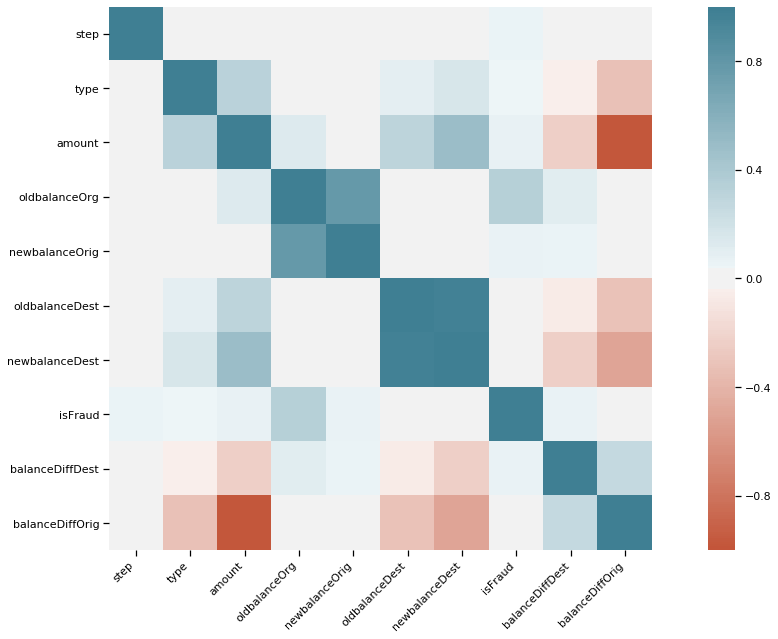

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')

corr = payments_df_encoded.corr()
#print(corr)

f = plt.figure(figsize=(20,10))
ax = sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')



From the correlation plot we can see that
- balancediffRig and amount are highly -ve correlated.
- oldbalancedest and newbalancedest are highly +ve correlated.


Separate the features and the class columns. 

In [17]:
X_df = payments_df_encoded.drop(columns=["isFraud"], axis=1)
y_df = payments_df_encoded['isFraud']
##print(X_df.head())
##print(y_df.head())
print(X_df.shape)
print(y_df.shape)

(2770409, 9)
(2770409,)


Split the training and testing datasets. Since the data is heavily imbalanced, we will used stratified splitting in order to get a similar ratio of the fraud transactions in both the training and testing datasets.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, 
                                                    test_size = .2, 
                                                    stratify = y_df,
                                                    random_state = 42)

In [22]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2216327, 9) (554082, 9) (2216327,) (554082,)


In [19]:
train_fraud_cnt = y_train.loc[(y_train == 1)].value_counts()
train_cnt = y_train.shape[0]


print(train_fraud_cnt / train_cnt)

test_fraud_cnt = y_test.loc[(y_test == 1)].value_counts()
test_cnt = y_test.shape[0]
print(test_fraud_cnt / test_cnt)


1    0.002964
Name: isFraud, dtype: float64
1    0.002965
Name: isFraud, dtype: float64


Using stratification we got equal ratios of Fraud transactions in training and testing datasets.

We need to set aside data for validation. We will create a validation set from the training set. We will set aside 10% of the training set for validation. We will use stratified splitting for creating the validation set.

In [20]:
X, X_val, y, y_val = train_test_split(X_train, y_train, 
                                                    test_size = .1, 
                                                    stratify = y_train,
                                                    random_state = 42)

In [21]:
print(X.shape, X_val.shape, y.shape, y_val.shape)

#creating multiple copies of X and Y to use for various algorithms
X1=X
y1=y
X2=X
y2=y
X3=X
y3=y
X4=X
y4=y
X5=X
y5=y
X6=X
y6=y
X7=X
y7=y


X_train1 = X_train
y_train1 = y_train
X_train2 = X_train
y_train2 = y_train
X_train3 = X_train
y_train3 = y_train
X_train4 = X_train
y_train4 = y_train



(1994694, 9) (221633, 9) (1994694,) (221633,)


In [23]:
print(y.loc[y == 1].value_counts())
print(y_val.loc[y_val == 1].value_counts())

1    5913
Name: isFraud, dtype: int64
1    657
Name: isFraud, dtype: int64


In [24]:
filtered_payments_df.loc[filtered_payments_df.isFraud == 1].shape

(8213, 10)

Even after just retaining the Transfer and Cash_out transactions the filtered dataset is still heavily imbalanced. There ratio of the fraud transactions total filtered transactions is around 0.3%. This may underfit the model and may result in in accurate model. It's better to conduct SMOTE analysis of the training data. We will upsample the fraud transactions.

In [57]:
sm = SMOTE(sampling_strategy='minority',random_state=42) 
X_upsampled, y_upsampled = sm.fit_sample(X, y)

In [58]:
print(X_upsampled.shape, y_upsampled.shape)

(3977562, 9) (3977562,)


In [59]:
#print(y_upsampled.loc[y_upsampled == 1].value_counts())
print(np.bincount(y_upsampled))

[1988781 1988781]


Oversampling for K-Fold Stratification

# Random Forest classifier

In [24]:
from sklearn.model_selection import StratifiedKFold
skfolds = StratifiedKFold(n_splits=6, random_state=42)

clf_rf = RandomForestClassifier(n_estimators=25, random_state=42)
sm = SMOTE(sampling_strategy='minority',random_state=42) 

# We use enumerate() to return also the index position of the list so that we can print out the fold number
for fold, (train_index, val_index) in enumerate(skfolds.split(X1, y1)):
    #print(train_index, val_index)
    X_train_fold = X.iloc[train_index]
    y_train_fold = y.iloc[train_index]
    X_val_fold = X.iloc[val_index]
    y_val_fold = y.iloc[val_index]
    X_train_fold_oversample, y_train_fold_oversample = sm.fit_sample(X_train_fold, y_train_fold)
    clf_rf.fit(X_train_fold_oversample, y_train_fold_oversample)
    y_val_fold_pred = clf_rf.predict(X_val_fold)
    print('Accuracy score for {} fold: {}'.format(fold, accuracy_score(y_val_fold,y_val_fold_pred)))
    print('Recall score for {} fold: {}'.format(fold, recall_score(y_val_fold, y_val_fold_pred)))


Accuracy score for 0 fold: 0.9999458565197774
Recall score for 0 fold: 0.9969574036511156
Accuracy score for 1 fold: 0.9999578884042714
Recall score for 1 fold: 0.9939148073022313
Accuracy score for 2 fold: 0.9999428485486539
Recall score for 2 fold: 0.9939148073022313
Accuracy score for 3 fold: 0.9999278082587352
Recall score for 3 fold: 0.9939086294416244
Accuracy score for 4 fold: 0.9999548801617095
Recall score for 4 fold: 0.9959390862944163
Accuracy score for 5 fold: 0.9999639041293676
Recall score for 5 fold: 0.9989847715736041


Feature importance of Random Forest Classifier

In [25]:
importances = (clf_rf.feature_importances_ )
features = X_df.columns
print(features)
feature_imp_df = pd.DataFrame(data=zip(features, importances), columns=['features', 'importances'])
feature_imp_df

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'balanceDiffDest',
       'balanceDiffOrig'],
      dtype='object')


,features,importances
0,step,0.026909
1,type,0.006465
2,amount,0.032528
3,oldbalanceOrg,0.176996
4,newbalanceOrig,0.158297
5,oldbalanceDest,0.042278
6,newbalanceDest,0.057901
7,balanceDiffDest,0.039974
8,balanceDiffOrig,0.458652


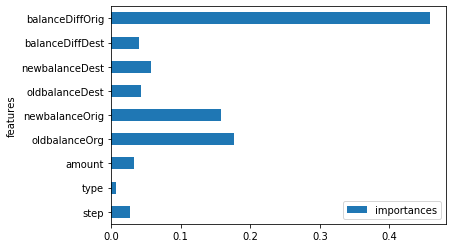

In [27]:
from matplotlib import pyplot as plt

barplot = feature_imp_df.plot.barh(x='features', y = 'importances')
barplot

Using the test data that was split before the kfold split we can validate the accuracy of the model

In [65]:
y_val_pred = clf_rf.predict(X_val)

In [68]:
print('Accuracy score: {}'.format(accuracy_score(y_val,y_val_pred)))
print('Recall score: {}'.format(recall_score(y_val, y_val_pred)))

Accuracy score: 0.9999323205479328
Recall score: 0.9969558599695586


In [76]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_val, y_val_pred)

0.9805389221556886

In [72]:
recall_score(y_val, y_val_pred)

0.9969558599695586

In [73]:
from sklearn.metrics import f1_score
f1_score(y_val, y_val_pred)

0.9886792452830189

In [92]:
clf_rf.classes_

array([0, 1])

Calculate the precision and accuracy scores on the Testing data.

In [117]:
y_test_pred = clf_rf.predict(X_test)

*****************************************************************
Area under the curve : 0.998454
Average precision-recall score RF: 0.9807989434955467
[[552412     27]
 [     5   1638]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.98      1.00      0.99      1643

    accuracy                           1.00    554082
   macro avg       0.99      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

*****************************************************************


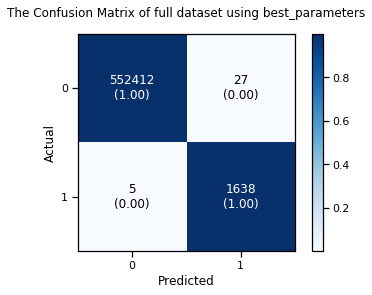

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


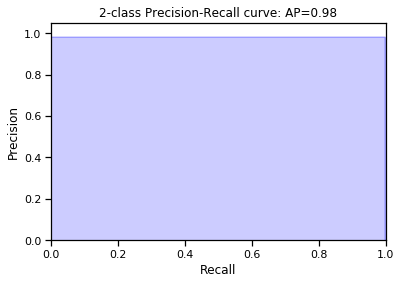

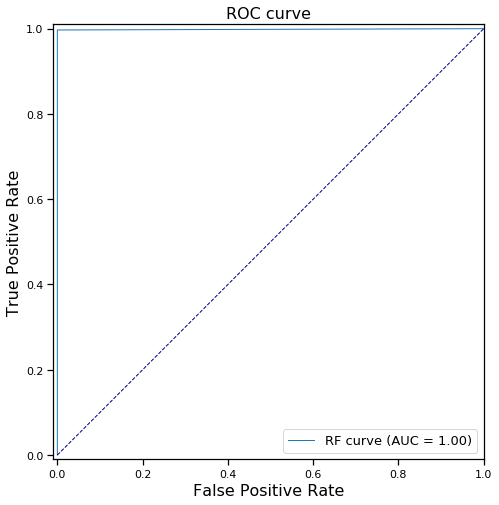

In [120]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
average_precision = average_precision_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred)
class_report
print("*****************************************************************")
print("Area under the curve : %f" % (roc_auc_score(y_test, y_test_pred)))
print("Average precision-recall score RF: {}".format(average_precision))
print(cm)
print(class_report)
print("*****************************************************************")

def draw_confusion_matrix(CM):
    fig, ax = plot_confusion_matrix(conf_mat= CM, colorbar=True,
                                   show_absolute=True,
                                   show_normed=True)
    plt.title("The Confusion Matrix of full dataset using best_parameters")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    #print("The accuracy is "+str((CM[1,1]+CM[0,0])/(CM[0,0] + CM[0,1]+CM[1,0] + CM[1,1])*100) + " %")
    #print("The recall from the confusion matrix is "+ str(CM[1,1]/(CM[1,0] + CM[1,1])*100) +" %")

draw_confusion_matrix(cm)

precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

ROC Curve

Since the data is heavly imbalanced, the precision - recall gives correct performance measurment.

# SVM with k fold

In [25]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Applying SVM Algorithm
print("-----------------------------------------------------------------------------------")
print("                    Support Vector Machine on undersampled data                    ")              
print("-----------------------------------------------------------------------------------")

skfolds = StratifiedKFold(n_splits=10, random_state=42)
sc = StandardScaler()
classifier= svm.SVC(C= 1, kernel= 'linear', random_state= 0)
rus = RandomUnderSampler(random_state=0)

# We use enumerate() to return also the index position of the list so that we can print out the fold number
for fold, (train_index, val_index) in enumerate(skfolds.split(X2, y2)):
    #print(train_index, val_index)
    X_train_fold = X.iloc[train_index]
    y_train_fold = y.iloc[train_index]
    X_val_fold = X.iloc[val_index]
    y_val_fold = y.iloc[val_index]
   
    X_train_fold = sc.fit_transform(X_train_fold)
    X_val_fold = sc.transform(X_val_fold)   

    X_train_fold_undersample, y_train_fold_undersample = rus.fit_sample(X_train_fold, y_train_fold)
    
    classifier.fit(X_train_fold_undersample, y_train_fold_undersample)
    
    y_val_fold_pred = classifier.predict(X_val_fold)
    print('Accuracy score for {} fold: {}'.format(fold, accuracy_score(y_val_fold,y_val_fold_pred)))
    print('Recall score for {} fold: {}'.format(fold, recall_score(y_val_fold, y_val_fold_pred)))

-----------------------------------------------------------------------------------
                    Support Vector Machine on undersampled data                    
-----------------------------------------------------------------------------------
Accuracy score for 0 fold: 0.939249314436685
Recall score for 0 fold: 0.8986486486486487
Accuracy score for 1 fold: 0.9399759362310122
Recall score for 1 fold: 0.8682432432432432
Accuracy score for 2 fold: 0.9421567152955331
Recall score for 2 fold: 0.9121621621621622
Accuracy score for 3 fold: 0.9378299384866822
Recall score for 3 fold: 0.922165820642978
Accuracy score for 4 fold: 0.9430337546185121
Recall score for 4 fold: 0.8781725888324873
Accuracy score for 5 fold: 0.9386270548305752
Recall score for 5 fold: 0.8849407783417935
Accuracy score for 6 fold: 0.9404218199319192
Recall score for 6 fold: 0.9204737732656514
Accuracy score for 7 fold: 0.9375391664870231
Recall score for 7 fold: 0.922165820642978
Accuracy score for 8 fold: 0.93

Using the test data that was split before on top we can validate the accuracy of the model

In [26]:
#Applying SVM over validation dataset

X_val_stard = sc.fit_transform(X_val)
y_val_pred = classifier.predict(X_val_stard)

from sklearn.metrics import precision_score, recall_score
print("Precision score: ",precision_score(y_val, y_val_pred))
print("Recall score: ",recall_score(y_val, y_val_pred))
print("Accuracy Score: ",accuracy_score(y_val, y_val_pred))

from sklearn.metrics import f1_score
print("F1 Score: ",f1_score(y_val, y_val_pred))


Precision score:  0.04131593714927048
Recall score:  0.8964992389649924
Accuracy Score:  0.9380281817238407
F1 Score:  0.0789914839401864


Applying the SVM over test data

*****************************************************************
Area under the curve for SVM K-fold : 0.915467
Average precision-recall score RF: 0.03732174336112809
[[518554  33885]
 [   177   1466]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    552439
           1       0.04      0.89      0.08      1643

    accuracy                           0.94    554082
   macro avg       0.52      0.92      0.52    554082
weighted avg       1.00      0.94      0.97    554082

*****************************************************************


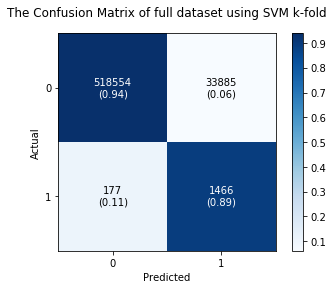

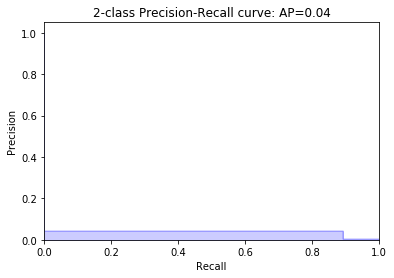

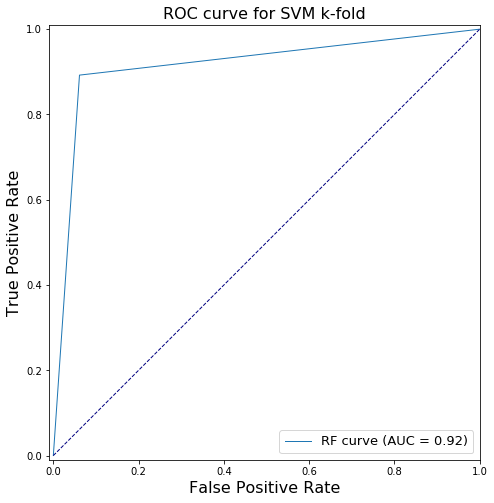

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score
from mlxtend.plotting import plot_confusion_matrix

X_test = sc.transform(X_test)
y_test_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
average_precision = average_precision_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred)
class_report
print("*****************************************************************")
print("Area under the curve for SVM K-fold : %f" % (roc_auc_score(y_test, y_test_pred)))
print("Average precision-recall score RF: {}".format(average_precision))
print(cm)
print(class_report)
print("*****************************************************************")

def draw_confusion_matrix(CM):
    fig, ax = plot_confusion_matrix(conf_mat= CM, colorbar=True,
                                   show_absolute=True,
                                   show_normed=True)
    plt.title("The Confusion Matrix of full dataset using SVM k-fold")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    #print("The accuracy is "+str((CM[1,1]+CM[0,0])/(CM[0,0] + CM[0,1]+CM[1,0] + CM[1,1])*100) + " %")
    #print("The recall from the confusion matrix is "+ str(CM[1,1]/(CM[1,0] + CM[1,1])*100) +" %")

draw_confusion_matrix(cm)

precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve for SVM k-fold', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

# Feature importance of SVM classifier

In [55]:
from matplotlib import pyplot as plt

features_names = X_df.columns
coefs_with_fns = zip(features_names,abs(classifier.coef_[0]))
feature_imp_df_SVM=pd.DataFrame(data= coefs_with_fns, columns=['features', 'importances'])
feature_imp_df_SVM

,features,importances
0,step,0.332842
1,type,0.428442
2,amount,2.697605
3,oldbalanceOrg,2.850544
4,newbalanceOrig,1.696864
5,oldbalanceDest,0.402643
6,newbalanceDest,0.693703
7,balanceDiffDest,4.355867
8,balanceDiffOrig,3.833660


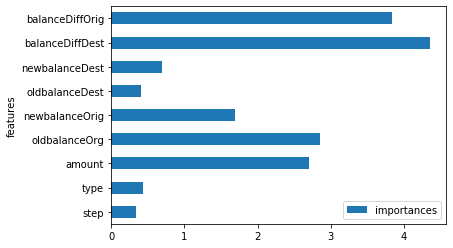

In [56]:
from matplotlib import pyplot as plt

barplot_SVM = feature_imp_df_SVM.plot.barh(x='features', y = 'importances')
barplot_SVM

# SVM k-fold HyperParameter Tuning 

In [39]:
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

sc = StandardScaler()
X_val = sc.fit_transform(X_val)

rus = RandomUnderSampler(random_state=0)
X_val_undersample, y_val_undersample = rus.fit_sample(X_val, y_val)

parameters = [{'C': [1, 10, 100,1000], 'kernel': ['linear']},
              {'C': [1, 10, 100,1000], 'kernel': ['rbf'], 'gamma': [1,0.1,0.001, 0.0001]}]


grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(X_val_undersample, y_val_undersample)
best_accuracy = grid_search.best_score_
print("The best accuracy using gridSearch is", best_accuracy)

best_parameters = grid_search.best_params_
print("The best parameters for using this model is", best_parameters)

print("Model after tuning *************")
print(grid_search.best_estimator_) 

The best accuracy using gridSearch is 0.9710806697108066
The best parameters for using this model is {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
Model after tuning *************
SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


# Fitting the SVM k fold classifier with best parameters


In [41]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

print("-----------------------------------------------------------------------------------")
print("                    Support Vector Machine training hyper parameter tuning         ")              
print("-----------------------------------------------------------------------------------")

skfolds = StratifiedKFold(n_splits=10, random_state=42)
sc = StandardScaler()

classifier_w_best_parameter= svm.SVC(C= 1000, kernel= 'rbf', gamma= 0.1)
rus = RandomUnderSampler(random_state=0)

# We use enumerate() to return also the index position of the list so that we can print out the fold number
for fold, (train_index, val_index) in enumerate(skfolds.split(X3, y3)):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_val_fold = X_train.iloc[val_index]
    y_val_fold = y_train.iloc[val_index]
    
    X_train_fold = sc.fit_transform(X_train_fold)
    X_val_fold = sc.transform(X_val_fold)   
    
    X_train_fold_undersample, y_train_fold_undersample = rus.fit_sample(X_train_fold, y_train_fold)
    
    classifier_w_best_parameter.fit(X_train_fold_undersample, y_train_fold_undersample)
    
    y_val_fold_pred = classifier_w_best_parameter.predict(X_val_fold)
    print('Accuracy score for {} fold: {}'.format(fold, accuracy_score(y_val_fold,y_val_fold_pred)))
    print('Recall score for {} fold: {}'.format(fold, recall_score(y_val_fold, y_val_fold_pred)))

-----------------------------------------------------------------------------------
                    Support Vector Machine training hyper parameter tuning         
-----------------------------------------------------------------------------------
Accuracy score for 0 fold: 0.9763023196354357
Recall score for 0 fold: 0.9951298701298701
Accuracy score for 1 fold: 0.9769789943349877
Recall score for 1 fold: 0.9888535031847133
Accuracy score for 2 fold: 0.9757758058855969
Recall score for 2 fold: 0.9964788732394366
Accuracy score for 3 fold: 0.9777960485087909
Recall score for 3 fold: 0.9886178861788618
Accuracy score for 4 fold: 0.9772696509232011
Recall score for 4 fold: 0.988135593220339
Accuracy score for 5 fold: 0.9781369536118394
Recall score for 5 fold: 0.9845094664371773
Accuracy score for 6 fold: 0.9775353563711654
Recall score for 6 fold: 0.9926873857404022
Accuracy score for 7 fold: 0.9785330051286165
Recall score for 7 fold: 0.9949409780775716
Accuracy score for 8 fold: 0.

In [42]:
#Applying SVM with best parameter over validation dataset

X_val_stard = sc.fit_transform(X_val)
y_val_pred = classifier_w_best_parameter.predict(X_val_stard)

from sklearn.metrics import precision_score, recall_score
print("Precision score: ",precision_score(y_val, y_val_pred))
print("Recall score: ",recall_score(y_val, y_val_pred))
print("Accuracy Score: ",accuracy_score(y_val, y_val_pred))

from sklearn.metrics import f1_score
print("F1 Score: ",f1_score(y_val, y_val_pred))

Precision score:  0.10135030265404314
Recall score:  0.9939117199391172
Accuracy Score:  0.9738576836481931
F1 Score:  0.18394366197183096


# SVM k-fold Test dataset with best parameters

*****************************************************************
Area under the curve after SVM Hyperparameter tuning: 0.983565
Average precision-recall score RF: 0.10075771282186187
[[537979  14460]
 [    11   1632]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    552439
           1       0.10      0.99      0.18      1643

    accuracy                           0.97    554082
   macro avg       0.55      0.98      0.59    554082
weighted avg       1.00      0.97      0.98    554082

*****************************************************************


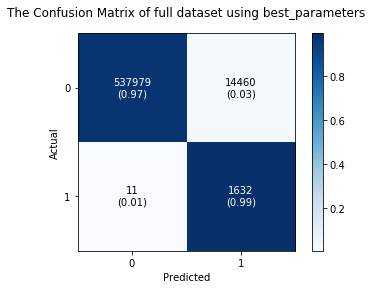

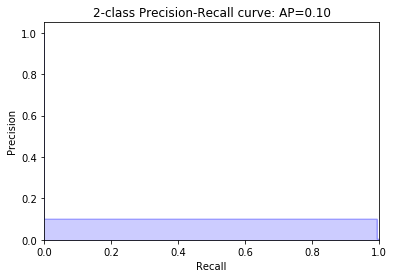

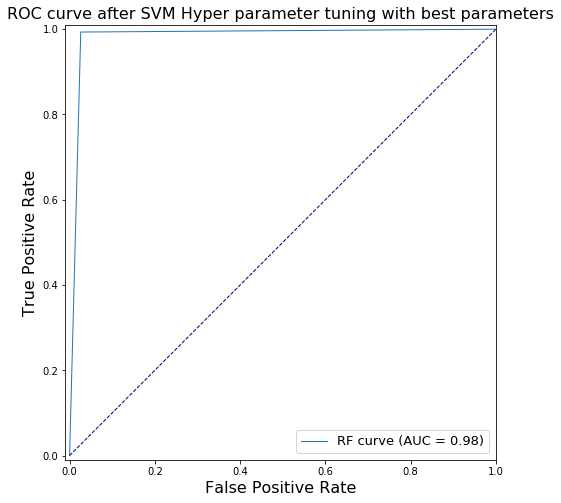

In [43]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

y_test_pred = classifier_w_best_parameter.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
average_precision = average_precision_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred)
class_report
print("*****************************************************************")
print("Area under the curve after SVM Hyperparameter tuning: %f" % (roc_auc_score(y_test, y_test_pred)))
print("Average precision-recall score RF: {}".format(average_precision))
print(cm)
print(class_report)
print("*****************************************************************")

def draw_confusion_matrix(CM):
    fig, ax = plot_confusion_matrix(conf_mat= CM, colorbar=True,
                                   show_absolute=True,
                                   show_normed=True)
    plt.title("The Confusion Matrix of full dataset using best_parameters")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    #print("The accuracy is "+str((CM[1,1]+CM[0,0])/(CM[0,0] + CM[0,1]+CM[1,0] + CM[1,1])*100) + " %")
    #print("The recall from the confusion matrix is "+ str(CM[1,1]/(CM[1,0] + CM[1,1])*100) +" %")

draw_confusion_matrix(cm)

precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve after SVM Hyper parameter tuning with best parameters', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

Result:
     SVM is able to predict with better accuracy after hyper parameter tuning

# SVM without k-fold

Done to compare the results of SVM k-fold and without k-fold

In [41]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Applying SVM Algorithm
print("-----------------------------------------------------------------------------------")
print("                    Support Vector Machine on undersampled data                    ")              
print("-----------------------------------------------------------------------------------")
    
sc = StandardScaler()
model= svm.SVC(C= 1, kernel= 'linear', random_state= 0)
rus = RandomUnderSampler(random_state=0)

X_train_fold = sc.fit_transform(X)
X_val_fold = sc.transform(X_val)   


X_train_fold_undersample, y_train_fold_undersample = rus.fit_sample(X_train_fold, y)

model.fit(X_train_fold_undersample, y_train_fold_undersample)

y_val_fold_pred = model.predict(X_val_fold)
print('Accuracy score ',( accuracy_score(y_val,y_val_fold_pred)))
print('Recall score ',(recall_score(y_val, y_val_fold_pred)))

-----------------------------------------------------------------------------------
                    Support Vector Machine on undersampled data                    
-----------------------------------------------------------------------------------
Accuracy score  0.808268624257218
Recall score  0.4764079147640791


In [42]:
#Applying SVM over validation dataset

X_val_stard = sc.fit_transform(X_val)
y_val_pred = model.predict(X_val_stard)

from sklearn.metrics import precision_score, recall_score
print("Precision score: ",precision_score(y_val, y_val_pred))
print("Recall score: ",recall_score(y_val, y_val_pred))
print("Accuracy Score: ",accuracy_score(y_val, y_val_pred))

from sklearn.metrics import f1_score
print("F1 Score: ",f1_score(y_val, y_val_pred))

Precision score:  0.04096301465457083
Recall score:  0.893455098934551
Accuracy Score:  0.9376762485730915
F1 Score:  0.07833455661573363


Applying SVM over test data

*****************************************************************
Area under the curve : 0.914383
Average precision-recall score RF: 0.03698299331025157
[[518365  34074]
 [   180   1463]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    552439
           1       0.04      0.89      0.08      1643

    accuracy                           0.94    554082
   macro avg       0.52      0.91      0.52    554082
weighted avg       1.00      0.94      0.97    554082

*****************************************************************


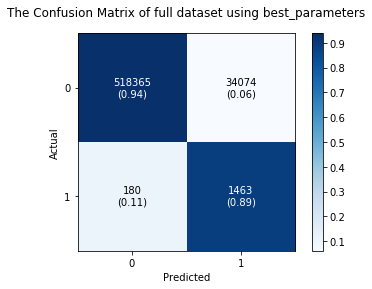

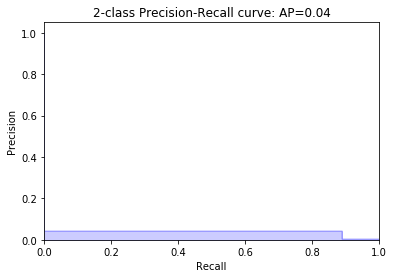

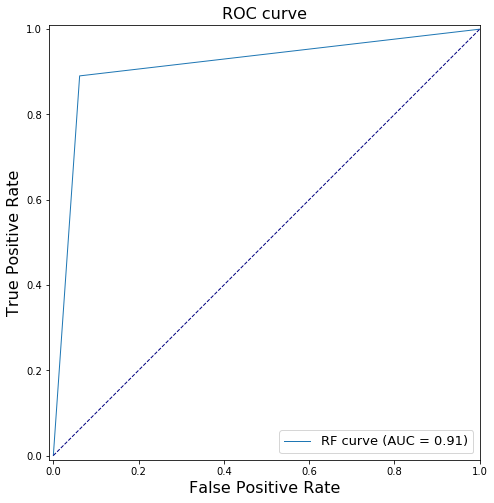

In [43]:
# X_test = sc.transform(X_test)
y_test_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
average_precision = average_precision_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred)
class_report
print("*****************************************************************")
print("Area under the curve : %f" % (roc_auc_score(y_test, y_test_pred)))
print("Average precision-recall score RF: {}".format(average_precision))
print(cm)
print(class_report)
print("*****************************************************************")

def draw_confusion_matrix(CM):
    fig, ax = plot_confusion_matrix(conf_mat= CM, colorbar=True,
                                   show_absolute=True,
                                   show_normed=True)
    plt.title("The Confusion Matrix of full dataset using best_parameters")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    #print("The accuracy is "+str((CM[1,1]+CM[0,0])/(CM[0,0] + CM[0,1]+CM[1,0] + CM[1,1])*100) + " %")
    #print("The recall from the confusion matrix is "+ str(CM[1,1]/(CM[1,0] + CM[1,1])*100) +" %")

draw_confusion_matrix(cm)

precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

# SVM Hyperparameter tuning

In [44]:
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')


rus = RandomUnderSampler(random_state=0)
X_train_fold_undersample, y_train_fold_undersample = rus.fit_sample(X_val, y_val)

param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose=2)
grid.fit(X_train_fold_undersample,y_train_fold_undersample)

best_accuracy = grid.best_score_
print("The best accuracy using gridSearch is", best_accuracy)

best_parameters = grid.best_params_
print("The best parameters for using this model is", best_parameters)

print("Model after tuning *************")
print(grid.best_estimator_) 

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] .................. C=1, gamma=0.001, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] .................. C=1, gamma=0.001, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] .................. C=1, gamma=0.001, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[CV] ............... C=100, gamma=0.0001, kernel=linear, total=   0.1s
[CV] C=100, gamma=0.0001, kernel=linear ..............................
[CV] ............... C=100, gamma=0.0001, kernel=linear, total=   0.1s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=100, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=100, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=100, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ................... C=1000, gamma=1, kernel=linear, total=   0.7s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ................... C=1000, gamma=1, kernel=linear, total=   1.4s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   14.9s finished


# Fitting the SVM classifier by using the best parameters

#fitting the SVM model with the best parameters
model_with_best_parameter= svm.SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

rus = RandomUnderSampler(random_state=0)

X_train_fold_undersample, y_train_fold_undersample = rus.fit_sample(X_train_fold, y)

model_with_best_parameter.fit(X_train_fold_undersample, y_train_fold_undersample)

y_val_fold_pred = model_with_best_parameter.predict(X_val_fold)
print('Accuracy score ',( accuracy_score(y_val,y_val_fold_pred)))
print('Recall score ',(recall_score(y_val, y_val_fold_pred)))

In [46]:
#Applying SVM with best parameter over validation dataset

X_val_stard = sc.fit_transform(X_val)
y_val_pred = model_with_best_parameter.predict(X_val_stard)

from sklearn.metrics import precision_score, recall_score
print("Precision score: ",precision_score(y_val, y_val_pred))
print("Recall score: ",recall_score(y_val, y_val_pred))
print("Accuracy Score: ",accuracy_score(y_val, y_val_pred))

from sklearn.metrics import f1_score
print("F1 Score: ",f1_score(y_val, y_val_pred))

Precision score:  0.09876543209876543
Recall score:  0.974124809741248
Accuracy Score:  0.9735734299495111
F1 Score:  0.17934706459296623


SVM Test dataset with best parameters

*****************************************************************
Area under the curve : 0.971272
Average precision-recall score RF: 0.09540147136877627
[[537846  14593]
 [    51   1592]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    552439
           1       0.10      0.97      0.18      1643

    accuracy                           0.97    554082
   macro avg       0.55      0.97      0.58    554082
weighted avg       1.00      0.97      0.98    554082

*****************************************************************


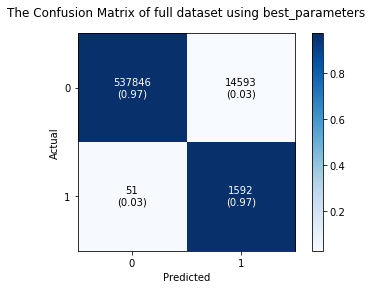

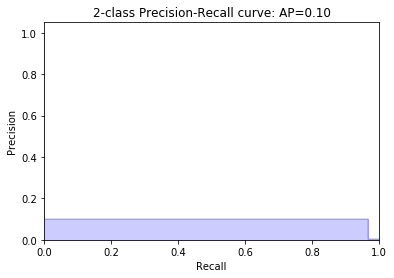

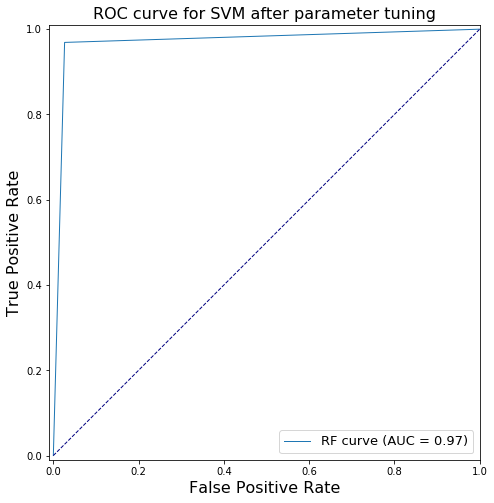

In [49]:
y_test_pred = model_with_best_parameter.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
average_precision = average_precision_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred)
class_report
print("*****************************************************************")
print("Area under the curve : %f" % (roc_auc_score(y_test, y_test_pred)))
print("Average precision-recall score RF: {}".format(average_precision))
print(cm)
print(class_report)
print("*****************************************************************")

def draw_confusion_matrix(CM):
    fig, ax = plot_confusion_matrix(conf_mat= CM, colorbar=True,
                                   show_absolute=True,
                                   show_normed=True)
    plt.title("The Confusion Matrix of full dataset using best_parameters")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    #print("The accuracy is "+str((CM[1,1]+CM[0,0])/(CM[0,0] + CM[0,1]+CM[1,0] + CM[1,1])*100) + " %")
    #print("The recall from the confusion matrix is "+ str(CM[1,1]/(CM[1,0] + CM[1,1])*100) +" %")

draw_confusion_matrix(cm)

precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve for SVM after parameter tuning', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

Comparing SVM k-fold and non k-fold: SVM with K-fold is able to predict with better accuracy

# Logistic Regression

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

skfolds = StratifiedKFold(n_splits=6, random_state=42)
lr_clf = LogisticRegression(solver='lbfgs')

sm = SMOTE(sampling_strategy='minority',random_state=42) 

# We use enumerate() to return also the index position of the list so that we can print out the fold number
for fold, (train_index, val_index) in enumerate(skfolds.split(X4, y4)):
    #print(train_index, val_index)
    X_train_fold = X.iloc[train_index]
    y_train_fold = y.iloc[train_index]
    X_val_fold = X.iloc[val_index]
    y_val_fold = y.iloc[val_index]
    X_train_fold_oversample, y_train_fold_oversample = sm.fit_sample(X_train_fold, y_train_fold)
    lr_clf.fit(X_train_fold_oversample, y_train_fold_oversample)
   
    y_val_fold_pred = lr_clf.predict(X_val_fold)
    print('Accuracy score for {} fold: {}'.format(fold, accuracy_score(y_val_fold,y_val_fold_pred)))
    print('Recall score for {} fold: {}'.format(fold, recall_score(y_val_fold, y_val_fold_pred)))

Accuracy score for 0 fold: 0.9057903444126937
Recall score for 0 fold: 0.962474645030426
Accuracy score for 1 fold: 0.9056339299142728
Recall score for 1 fold: 0.9716024340770791
Accuracy score for 2 fold: 0.9105038351631825
Recall score for 2 fold: 0.9584178498985801
Accuracy score for 3 fold: 0.8864093031090576
Recall score for 3 fold: 0.9776649746192894
Accuracy score for 4 fold: 0.8917996197901626
Recall score for 4 fold: 0.9685279187817258
Accuracy score for 5 fold: 0.887642578688998
Recall score for 5 fold: 0.9736040609137055


In [28]:
#Applying Logistic Regression over validation dataset

y_val_pred = lr_clf.predict(X_val)

from sklearn.metrics import precision_score, recall_score
print("Precision score: ",precision_score(y_val, y_val_pred))
print("Recall score: ",recall_score(y_val, y_val_pred))
print("Accuracy Score: ",accuracy_score(y_val, y_val_pred))

from sklearn.metrics import f1_score
print("F1 Score: ",f1_score(y_val, y_val_pred))

Precision score:  0.025053095256823723
Recall score:  0.969558599695586
Accuracy Score:  0.888062698244395
F1 Score:  0.0488440746846605


*****************************************************************
Area under the curve : 0.928537
Average precision-recall score RF: 0.024422240026521446
[[490629  61810]
 [    51   1592]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    552439
           1       0.03      0.97      0.05      1643

    accuracy                           0.89    554082
   macro avg       0.51      0.93      0.49    554082
weighted avg       1.00      0.89      0.94    554082

*****************************************************************


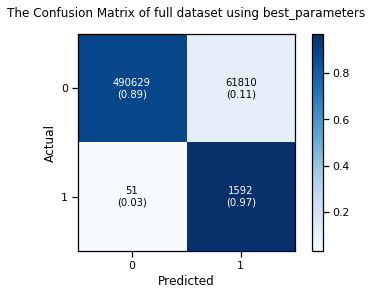

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


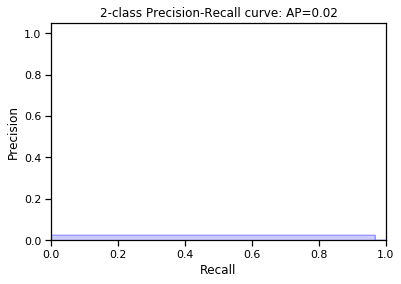

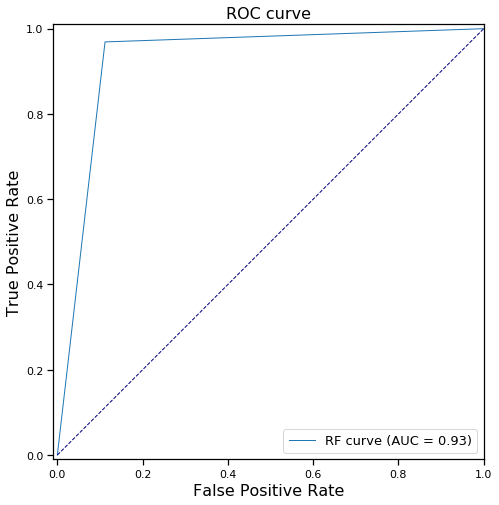

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score
from mlxtend.plotting import plot_confusion_matrix

y_test_pred = lr_clf.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
average_precision = average_precision_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred)
class_report
print("*****************************************************************")
print("Area under the curve : %f" % (roc_auc_score(y_test, y_test_pred)))
print("Average precision-recall score RF: {}".format(average_precision))
print(cm)
print(class_report)
print("*****************************************************************")

def draw_confusion_matrix(CM):
    fig, ax = plot_confusion_matrix(conf_mat= CM, colorbar=True,
                                   show_absolute=True,
                                   show_normed=True)
    plt.title("The Confusion Matrix of full dataset using best_parameters")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    #print("The accuracy is "+str((CM[1,1]+CM[0,0])/(CM[0,0] + CM[0,1]+CM[1,0] + CM[1,1])*100) + " %")
    #print("The recall from the confusion matrix is "+ str(CM[1,1]/(CM[1,0] + CM[1,1])*100) +" %")

draw_confusion_matrix(cm)

precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

# Logistic Regression Hyperparameter tuning

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

lr_clf_mod = LogisticRegression(solver='lbfgs')

#grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge

grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] , "penalty":['none',"l2"]}

# Create grid search using 10-fold cross validation
clf_lib_model = GridSearchCV(LogisticRegression(solver='lbfgs'),grid, scoring='accuracy', cv=10)

# Fit grid search
best_reg_model = clf_lib_model.fit(X_val, y_val)

# View best hyperparameters
print('Best Penalty:', best_reg_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_reg_model.best_estimator_.get_params()['C'])

best_accuracy_linear = best_reg_model.best_score_
print("The best accuracy using gridSearch is", best_accuracy_linear)

best_parameters_linear = best_reg_model.best_params_
print("The best parameters for using this model is", best_parameters_linear)

print("Model after tuning *************")
print(best_reg_model.best_estimator_)


Best Penalty: none
Best C: 0.001
The best accuracy using gridSearch is 0.9964626206386233
The best parameters for using this model is {'C': 0.001, 'penalty': 'none'}
Model after tuning *************
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


# Fitting Logistic Regression with best parameters

In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

skfolds = StratifiedKFold(n_splits=6, random_state=42)

lr_clf_best_model = LogisticRegression(C=0.001,  penalty='none', solver='lbfgs')

sm = SMOTE(sampling_strategy='minority',random_state=42) 

# We use enumerate() to return also the index position of the list so that we can print out the fold number
for fold, (train_index, val_index) in enumerate(skfolds.split(X5, y5)):
    #print(train_index, val_index)
    X_train_fold = X.iloc[train_index]
    y_train_fold = y.iloc[train_index]
    X_val_fold = X.iloc[val_index]
    y_val_fold = y.iloc[val_index]
    X_train_fold_oversample, y_train_fold_oversample = sm.fit_sample(X_train_fold, y_train_fold)
    lr_clf_best_model.fit(X_train_fold_oversample, y_train_fold_oversample)
   
    y_val_fold_pred = lr_clf_best_model.predict(X_val_fold)
    print('Accuracy score for {} fold: {}'.format(fold, accuracy_score(y_val_fold,y_val_fold_pred)))
    print('Recall score for {} fold: {}'.format(fold, recall_score(y_val_fold, y_val_fold_pred)))

Accuracy score for 0 fold: 0.9057903444126937
Recall score for 0 fold: 0.962474645030426
Accuracy score for 1 fold: 0.9056369378853963
Recall score for 1 fold: 0.9716024340770791
Accuracy score for 2 fold: 0.9105038351631825
Recall score for 2 fold: 0.9584178498985801
Accuracy score for 3 fold: 0.8864093031090576
Recall score for 3 fold: 0.9776649746192894
Accuracy score for 4 fold: 0.8917996197901626
Recall score for 4 fold: 0.9685279187817258
Accuracy score for 5 fold: 0.8876395706997786
Recall score for 5 fold: 0.9736040609137055


In [40]:
#Applying SVM over validation dataset

y_val_pred = lr_clf_best_model.predict(X_val)

from sklearn.metrics import precision_score, recall_score
print("Precision score: ",precision_score(y_val, y_val_pred))
print("Recall score: ",recall_score(y_val, y_val_pred))
print("Accuracy Score: ",accuracy_score(y_val, y_val_pred))

from sklearn.metrics import f1_score
print("F1 Score: ",f1_score(y_val, y_val_pred))

Precision score:  0.025053095256823723
Recall score:  0.969558599695586
Accuracy Score:  0.888062698244395
F1 Score:  0.0488440746846605


# Logistic Regression test dataset with best parameters

*****************************************************************
Area under the curve : 0.928537
Average precision-recall score RF: 0.024422240026521446
[[490629  61810]
 [    51   1592]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    552439
           1       0.03      0.97      0.05      1643

    accuracy                           0.89    554082
   macro avg       0.51      0.93      0.49    554082
weighted avg       1.00      0.89      0.94    554082

*****************************************************************


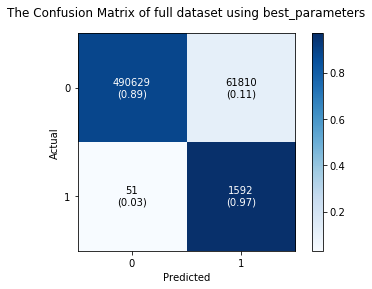

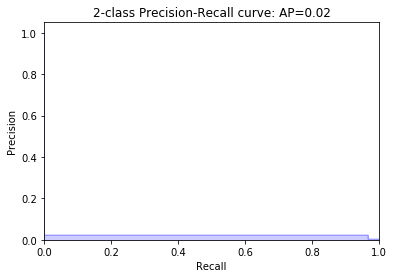

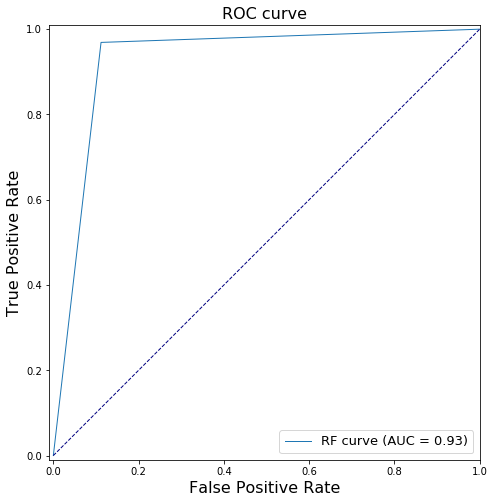

In [41]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score
from mlxtend.plotting import plot_confusion_matrix

y_test_pred = lr_clf_best_model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
average_precision = average_precision_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred)
class_report
print("*****************************************************************")
print("Area under the curve : %f" % (roc_auc_score(y_test, y_test_pred)))
print("Average precision-recall score RF: {}".format(average_precision))
print(cm)
print(class_report)
print("*****************************************************************")

def draw_confusion_matrix(CM):
    fig, ax = plot_confusion_matrix(conf_mat= CM, colorbar=True,
                                   show_absolute=True,
                                   show_normed=True)
    plt.title("The Confusion Matrix of full dataset using best_parameters")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    #print("The accuracy is "+str((CM[1,1]+CM[0,0])/(CM[0,0] + CM[0,1]+CM[1,0] + CM[1,1])*100) + " %")
    #print("The recall from the confusion matrix is "+ str(CM[1,1]/(CM[1,0] + CM[1,1])*100) +" %")

draw_confusion_matrix(cm)

precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

Result: Linear Regression dint show any improvement in result after hyper parameter tuning. 

# Feature importance of Linear Regression

In [44]:
importances_lin = abs(lr_clf_best_model.coef_[0] )
importances_lin = 100.0 * (importances_lin / importances_lin.max())
features = X_df.columns
print(features)
feature_imp_df_lin = pd.DataFrame(data=zip(features, importances_lin), columns=['features', 'importances'])
feature_imp_df_lin

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'balanceDiffDest',
       'balanceDiffOrig'],
      dtype='object')


,features,importances
0,step,0.041195
1,type,0.000454
2,amount,19.707819
3,oldbalanceOrg,58.813964
4,newbalanceOrig,60.893856
5,oldbalanceDest,27.388159
6,newbalanceDest,28.459691
7,balanceDiffDest,75.555670
8,balanceDiffOrig,100.000000


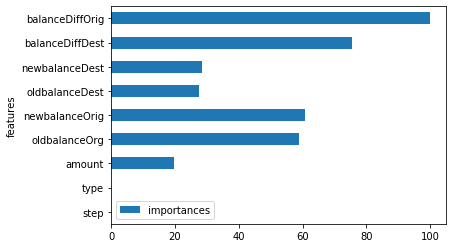

In [45]:
from matplotlib import pyplot as plt

barplot_lin = feature_imp_df_lin.plot.barh(x='features', y = 'importances')
barplot_lin

# Gradient Boosting with K-Fold

In [25]:
#Gradient Boosting K-Fold

#from xgboost.sklearn import XGBClassifier
#from sklearn.metrics import average_precision_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, precision_recall_curve

skfolds = StratifiedKFold(n_splits=16, random_state=42)

params = {
    'n_estimators': 10,
    'max_depth': 1,
    'learning_rate': 0.1,
}

sm = SMOTE(sampling_strategy='minority',random_state=42) 

kfolds = StratifiedKFold(n_splits=16, random_state=42)
sc = StandardScaler()

#classifier= svm.SVC(C= 1, kernel= 'linear', random_state= 0)

GBclassifier = GradientBoostingClassifier(**params)

rus = RandomUnderSampler(random_state=0)

# We use enumerate() to return also the index position of the list so that we can print out the fold number
for fold, (train_index, val_index) in enumerate(skfolds.split(X5, y5)):
    #print(train_index, val_index)
    X_train_fold5 = X.iloc[train_index]
    y_train_fold5 = y.iloc[train_index]
    X_val_fold5 = X.iloc[val_index]
    y_val_fold5 = y.iloc[val_index]
    
    X_train_fold5 = sc.fit_transform(X_train_fold5)
    X_val_fold5 = sc.transform(X_val_fold5)   

    X_train_fold_undersample5, y_train_fold_undersample5 = rus.fit_sample(X_train_fold5, y_train_fold5)
    
    GBclassifier.fit(X_train_fold_undersample5, y_train_fold_undersample5)
    
    y_val_fold_pred_GB = GBclassifier.predict(X_val_fold5)
    print('Accuracy score for {} fold: {}'.format(fold, accuracy_score(y_val_fold5,y_val_fold_pred_GB)))
    print('Recall score for {} fold: {}'.format(fold, recall_score(y_val_fold5,y_val_fold_pred_GB)))

Accuracy score for 0 fold: 0.9012424901138214
Recall score for 0 fold: 0.9891891891891892
Accuracy score for 1 fold: 0.9012825963150423
Recall score for 1 fold: 0.9972972972972973
Accuracy score for 2 fold: 0.8998387730710923
Recall score for 2 fold: 0.9945945945945946
Accuracy score for 3 fold: 0.902574015994353
Recall score for 3 fold: 0.9918918918918919
Accuracy score for 4 fold: 0.9028627806431431
Recall score for 4 fold: 0.9972972972972973
Accuracy score for 5 fold: 0.9011382139906472
Recall score for 5 fold: 0.9891891891891892
Accuracy score for 6 fold: 0.9018360618918897
Recall score for 6 fold: 0.9945945945945946
Accuracy score for 7 fold: 0.9018922105735989
Recall score for 7 fold: 0.9918918918918919
Accuracy score for 8 fold: 0.8998788792723131
Recall score for 8 fold: 0.9918918918918919
Accuracy score for 9 fold: 0.9002069496582924
Recall score for 9 fold: 0.991869918699187
Accuracy score for 10 fold: 0.9018914236211377
Recall score for 10 fold: 0.997289972899729
Accuracy sc

# Confusion Matrix Gradient Boosting with K-Fold

*****************************************************************
Area under the curve for Gradient Boosting K-fold : 0.948182
Average precision-recall score RF: 0.028966339665126854
[[497876  54563]
 [     8   1635]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    552439
           1       0.03      1.00      0.06      1643

    accuracy                           0.90    554082
   macro avg       0.51      0.95      0.50    554082
weighted avg       1.00      0.90      0.95    554082

*****************************************************************


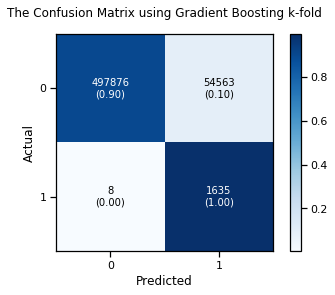

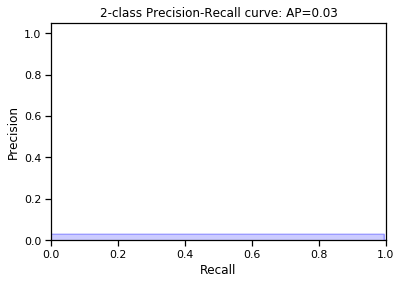

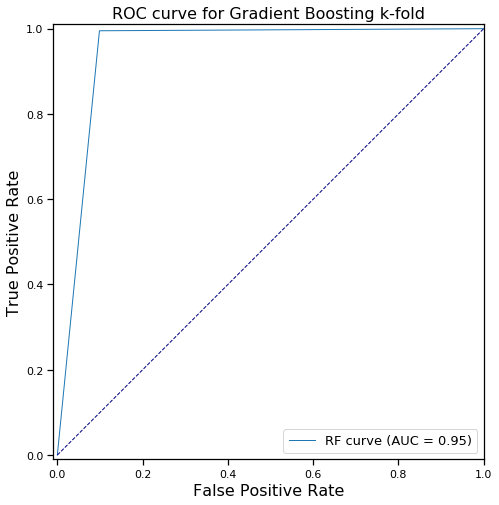

In [26]:
# Gradient Boosting Confusion Matrix test set before hyperparameter tuning

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score
from mlxtend.plotting import plot_confusion_matrix

y_test5 = y_test
X_test6 = sc.transform(X_test)
y_test_pred6 = GBclassifier.predict(X_test6)
cm = confusion_matrix(y_test5, y_test_pred6)
average_precision = average_precision_score(y_test5, y_test_pred6)
class_report = classification_report(y_test5, y_test_pred6)
class_report
print("*****************************************************************")
print("Area under the curve for Gradient Boosting K-fold : %f" % (roc_auc_score(y_test5, y_test_pred6)))
print("Average precision-recall score RF: {}".format(average_precision))
print(cm)
print(class_report)
print("*****************************************************************")

def draw_confusion_matrix(CM):
    fig, ax = plot_confusion_matrix(conf_mat= CM, colorbar=True, show_absolute=True, show_normed=True)
    plt.title("The Confusion Matrix using Gradient Boosting k-fold")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

draw_confusion_matrix(cm)

precision, recall, _ = precision_recall_curve(y_test5, y_test_pred6)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

fpr_rf, tpr_rf, _ = roc_curve(y_test5, y_test_pred6)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve for Gradient Boosting k-fold', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

# Gradient Boosting hyperparameter tunning

In [23]:
# Gradient Boosting Hyper-parameter tuning

from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier


import warnings
warnings.filterwarnings('ignore')

sc = StandardScaler()
X_val5 = sc.fit_transform(X_val)

rus = RandomUnderSampler(random_state=0)
X_val_undersample5, y_val_undersample5 = rus.fit_sample(X_val5, y_val)

params = {
    'n_estimators': 10,
    'max_depth': 1,
    'learning_rate': 0.1,
}
GBclassifier = GradientBoostingClassifier(**params)

#parameters = [{'C': [1, 10, 100,1000], 'kernel': ['linear']},
#              {'C': [1, 10, 100,1000], 'kernel': ['rbf'], 'gamma': [1,0.1,0.001, 0.0001]}]

parameters = {
    "learning_rate": [0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2],
    "max_depth":[3,5,8],
    "n_estimators":[1,2,3,4,5,10,15,16,17,18,19,20]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

grid_search = GridSearchCV(estimator = GBclassifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(X_val_undersample5, y_val_undersample5)
best_accuracy = grid_search.best_score_
print("The best accuracy using gridSearch is", best_accuracy)

best_parameters = grid_search.best_params_
print("The best parameters for using this model is", best_parameters)

print("Model after tuning *************")
print(grid_search.best_estimator_)


The best accuracy using gridSearch is 0.9969558599695586
The best parameters for using this model is {'learning_rate': 0.005, 'max_depth': 3, 'n_estimators': 2}
Model after tuning *************
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.005, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=2,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


# Fitting Gradient Boosting model with best parameters

In [27]:
#fitting the Gradient Boosting model with the best parameters

#GBmodel_with_best_parameter= svm.SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
#    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
#    max_iter=-1, probability=False, random_state=None, shrinking=True,
#    tol=0.001, verbose=False)


params_best = {
    'n_estimators': 3,
    'max_depth': 3,
    'learning_rate': 0.005,
}

GBmodel_with_best_parameter =  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.005, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=2,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

rus = RandomUnderSampler(random_state=0)
X_train_fold_undersample5, y_train_fold_undersample5 = rus.fit_sample(X_train_fold5, y_train_fold5)

GBmodel_with_best_parameter.fit(X_train_fold_undersample5, y_train_fold_undersample5)
y_val_fold_pred_GB = GBmodel_with_best_parameter.predict(X_val_fold5)

print('Accuracy score ',(accuracy_score(y_val_fold5,y_val_fold_pred_GB)))
print('Recall score ',(recall_score(y_val_fold5, y_val_fold_pred_GB)))

Accuracy score  0.9998074871457563
Recall score  1.0


# Gradient boosting Test Set with best parameters

*****************************************************************
Area under the curve : 0.998340
Average precision-recall score RF: 0.911798647647072
[[552286    153]
 [     5   1638]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.91      1.00      0.95      1643

    accuracy                           1.00    554082
   macro avg       0.96      1.00      0.98    554082
weighted avg       1.00      1.00      1.00    554082

*****************************************************************


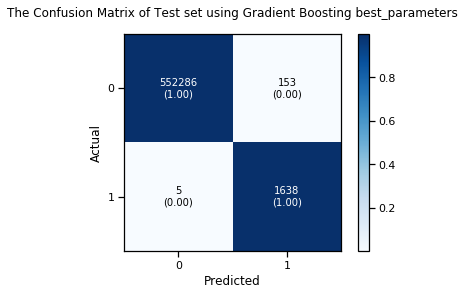

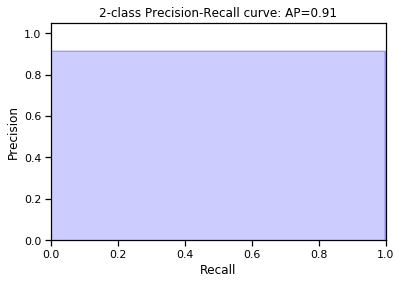

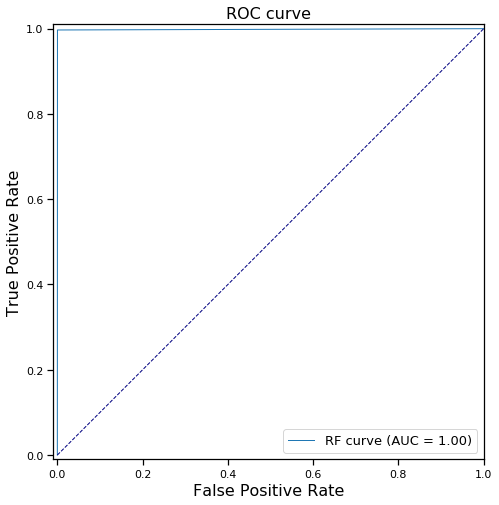

In [28]:
y_test5 = y_test
X_test8 = sc.transform(X_test)
y_test_pred8 = GBmodel_with_best_parameter.predict(X_test8)
cm6 = confusion_matrix(y_test5, y_test_pred8)
average_precision = average_precision_score(y_test5, y_test_pred8)
class_report = classification_report(y_test5, y_test_pred8)
class_report
print("*****************************************************************")
print("Area under the curve : %f" % (roc_auc_score(y_test5, y_test_pred8)))
print("Average precision-recall score RF: {}".format(average_precision))
print(cm6)
print(class_report)
print("*****************************************************************")

def draw_confusion_matrix(CM):
    fig, ax = plot_confusion_matrix(conf_mat= CM, colorbar=True,
                                   show_absolute=True,
                                   show_normed=True)
    plt.title("The Confusion Matrix of Test set using Gradient Boosting best_parameters")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

draw_confusion_matrix(cm6)

precision, recall, _ = precision_recall_curve(y_test5, y_test_pred8)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

fpr_rf, tpr_rf, _ = roc_curve(y_test5, y_test_pred8)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

# Feature importance Gradient Boosting - most important balanceDiffOrig

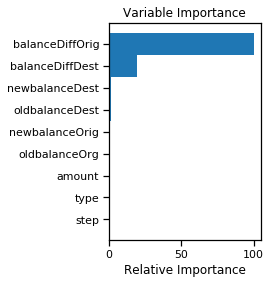

In [29]:
import chart_studio.plotly as py
import plotly.graph_objects as go

#feature_importance = clf.feature_importances_
feature_importance = GBmodel_with_best_parameter.feature_importances_
#feature_importance = GradientBoostingClassifier.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
#sorted_idx = np.argsort(feature_importance)[::-1]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='edge', alpha=1.0, height=-1.0)

width=1.0
plt.yticks(range(X_test.shape[1]), X_test.columns, rotation=0)

plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [30]:
# Visualisation

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#limit = len(X_df)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

#the payments_df_encoded is not used from here onwards.
# revert back to filtered and then binary encode the "type"

X_dfg = filtered_payments_df.drop(columns=["isFraud"], axis=1)
y_dfg = filtered_payments_df['isFraud']

print(X_dfg.shape)
print(y_dfg.shape)

# Binary-encoding of labelled data in 'type'
X_dfg.loc[X_dfg.type == 'TRANSFER', 'type'] = 0
X_dfg.loc[X_dfg.type == 'CASH_OUT', 'type'] = 1
X_dfg.type = X_dfg.type.astype(int) # convert dtype('O') to dtype(int)

# Simplify to X and Y
#X=X_dfg
#Y=y_dfg

X_dfg.head()



(2770409, 9)
(2770409,)


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,balanceDiffDest,balanceDiffOrig
2,1,1,181.00,181.0,0.0,0.0,0.00,181.0,0.00
3,1,0,181.00,181.0,0.0,21182.0,0.00,21363.0,0.00
15,1,0,229133.94,15325.0,0.0,5083.0,51513.44,182703.5,-213808.94
19,1,1,215310.30,705.0,0.0,22425.0,0.00,237735.3,-214605.30
24,1,1,311685.89,10835.0,0.0,6267.0,2719172.89,-2401220.0,-300850.89


# Correlation Heatmap

                     step      type    amount  oldbalanceOrg  newbalanceOrig  \
step             1.000000  0.016022  0.037007       0.005744       -0.011280   
type             0.016022  1.000000  0.326040       0.013202       -0.018726   
amount           0.037007  0.326040  1.000000       0.120389        0.018296   
oldbalanceOrg    0.005744  0.013202  0.120389       1.000000        0.778826   
newbalanceOrig  -0.011280 -0.018726  0.018296       0.778826        1.000000   
oldbalanceDest   0.037778  0.099794  0.307133      -0.020403       -0.012277   
newbalanceDest   0.037475  0.157024  0.497027      -0.010029       -0.015439   
balanceDiffDest  0.029010 -0.039197 -0.234198       0.113853        0.061630   
balanceDiffOrig -0.033936 -0.323657 -0.982838       0.030438        0.032263   

                 oldbalanceDest  newbalanceDest  balanceDiffDest  \
step                   0.037778        0.037475         0.029010   
type                   0.099794        0.157024        -0.03919

[Text(0.5, 0, 'step'),
 Text(1.5, 0, 'type'),
 Text(2.5, 0, 'amount'),
 Text(3.5, 0, 'oldbalanceOrg'),
 Text(4.5, 0, 'newbalanceOrig'),
 Text(5.5, 0, 'oldbalanceDest'),
 Text(6.5, 0, 'newbalanceDest'),
 Text(7.5, 0, 'balanceDiffDest'),
 Text(8.5, 0, 'balanceDiffOrig')]

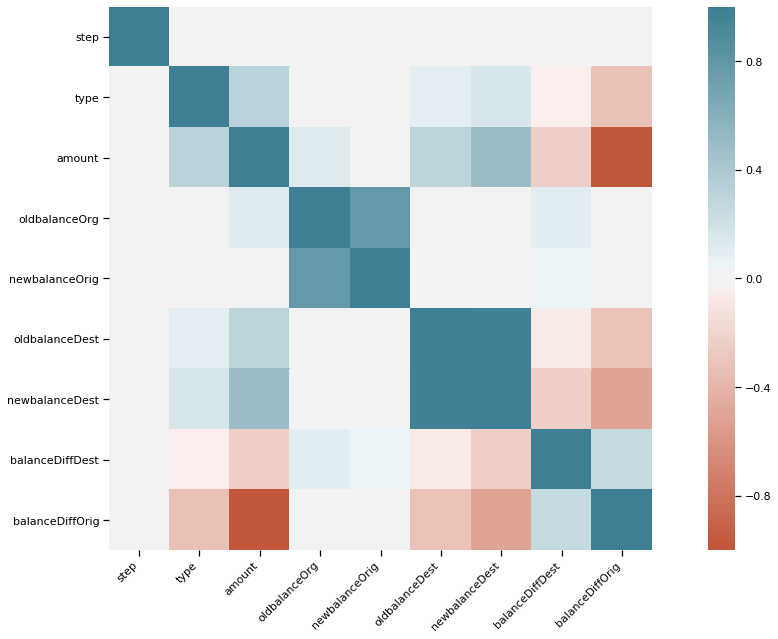

In [31]:
# Type = 0 or 1.
# Check correlation using heatmap

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')

#corr = payments_df_encoded.corr()
corr = X_dfg.corr()
print(corr)

f = plt.figure(figsize=(20,10))
ax = sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')


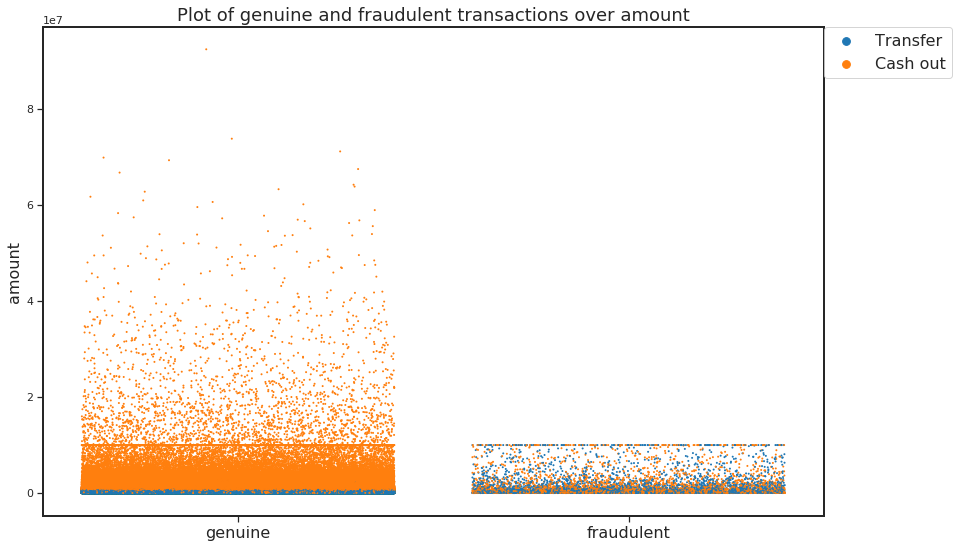

In [45]:
# Visualisation in 2D

limit = len(X_dfg)
ax = plotStrip(y_dfg[:limit], X_dfg.amount[:limit], X_dfg.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Plot of genuine and fraudulent transactions over amount', size = 18);

# 3D visualisation

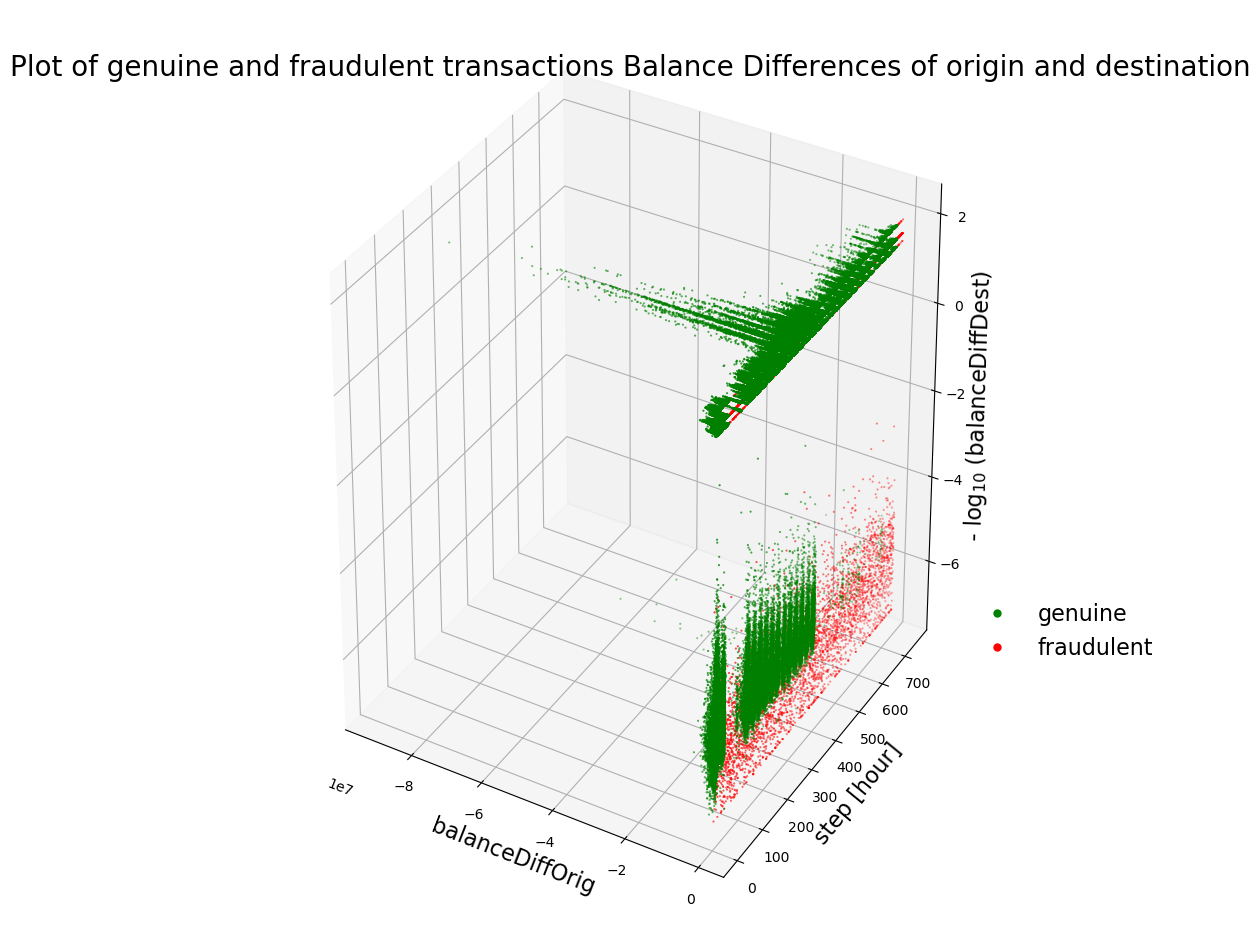

In [32]:
# Visualiation 3D (original)

# balanceDiffOrig is the leading indicator of x


X=X_dfg
Y=y_dfg

x = 'balanceDiffOrig'
y = 'step'
z = 'balanceDiffDest'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Plot of genuine and fraudulent transactions Balance Differences of origin and destination', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

# AdaBoost

Experiment with the AdaBoost classifer using the dataset.

We already have X_train, y_train, X_test and y_test and can just use them.

Create an AdaBoost model and fit it using grid search

Try a range of estimators and learning rates

NOTE: Setting max_features=4 in the decision tree classifier used as the base classifier for AdaBoost will increase the convergence rate

In [47]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_features=4, random_state=42), random_state=42)

param_grid = {'n_estimators': [100, 150, 200, 250, 300],
              'learning_rate': [0.1, 0.01, 0.001]}

GV_ABC = GridSearchCV(ada_clf,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

In [48]:
GV_ABC.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=4,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=42,
                               

In [49]:
GV_ABC.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [50]:
from sklearn.metrics import classification_report

y_pred = GV_ABC.predict(X_test)
print(classification_report(y_test, y_pred))
print('accuracy: ', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.99      0.99      0.99      1643

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

accuracy:  0.99995668511159


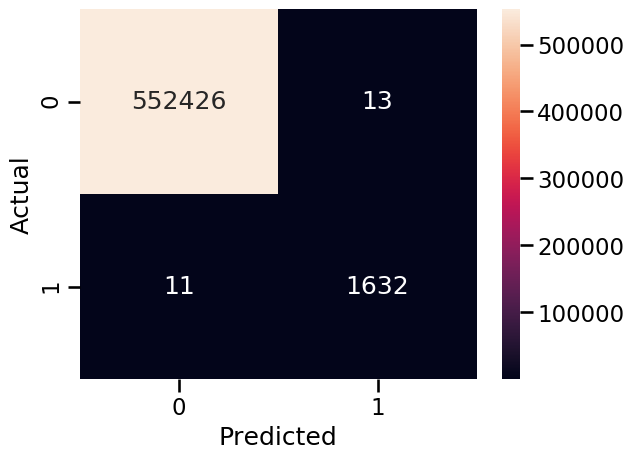

In [51]:
import seaborn as sns

#“paper”, “talk”, and “poster”
#.8, 1.3, and 1.6

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

labels = [0, 1, 2, 3, 4, 5]
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');